#  Import Libraries and Define Constants

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

dx_dy = 0.0333958286584664  
dt = 0.025 

base_directory = '../Data/TemporalData/'
image_base_directory = '../Data/SpatialData/'

i_range = [i for i in range(20, 54) if i not in {22, 26, 30, 34, 48}]  
j_range = range(1, 41)  


# Define Function for Pulse Scaling

In [2]:
def scale_pulse(image, pulse, dx_dy=dx_dy, dt=dt):
    image_energy = image.sum() * dx_dy  
    pulse_energy = pulse.sum() * dt  
    K = image_energy / pulse_energy  
    scaled_pulse = K * pulse  
    return scaled_pulse


#  Load and Preprocess Data

In [3]:
data = {}
for i in i_range:
    for j in j_range:
        # File paths
        input_pulse_file = os.path.join(base_directory, f'Run {i} - BL4, s39708', f'Run_{i}_BL4_s39708_InjPulsePower_InjEnergyFactor_{j}.csv')
        output_file = os.path.join(base_directory, f'Run {i} - BL4, s39708', f'Run_{i}_BL4_s39708_UVDBS_Power_InjEnergyFactor_{j}.csv')
        input_image_file = os.path.join(image_base_directory, f'Run {i} - BL4, s39708', f'Run_{i}_BL4_s39708_Inj_256x256_InjEnergyFactor_{j}.csv')
        
        if os.path.isfile(input_pulse_file) and os.path.isfile(output_file) and os.path.isfile(input_image_file):
            # Load data
            image_data = pd.read_csv(input_image_file, header=None).values
            input_pulse = pd.read_csv(input_pulse_file, header=None).iloc[0].values
            scaled_input_pulse = scale_pulse(image_data, input_pulse)  # Scale the pulse
            input_data = scaled_input_pulse[59:59+576]  # Truncate to 576 points
            output_data = pd.read_csv(output_file, header=None).iloc[0].values[59:59+576]  # Truncate

            # Store data in dictionary
            data[(i, j)] = {'input': input_data, 'output': output_data}
        else:
            print(f"Files not found for i={i}, j={j}: Skipping.")

print("Data loading complete.")


Data loading complete.


# Normalize Data

In [4]:
all_input_data = np.array([data[(i, j)]['input'] for i, j in data.keys()])
all_output_data = np.array([data[(i, j)]['output'] for i, j in data.keys()])

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

all_input_data = torch.tensor(input_scaler.fit_transform(all_input_data)).float()
all_output_data = torch.tensor(output_scaler.fit_transform(all_output_data)).float()


# Create Data Loaders

In [5]:
dataset = TensorDataset(all_input_data, all_output_data)
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Define Model Architecture

In [6]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
import joblib
scaler_folder = "final_op/ori_2_128/scalers"
input_scaler_path = os.path.join(scaler_folder, "best_input_scaler.pkl")
output_scaler_path = os.path.join(scaler_folder, "best_output_scaler.pkl")

# Train the Model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFeedForwardNN(input_dim=576, hidden_dim=128, output_dim=576).to(device)
criterion = nn.L1Loss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)

best_val_loss = float('inf')  # Start with a very high value
best_model_path = 'final_op/ori_2_128/o2_128.pth'

num_epochs = 50
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        joblib.dump(input_scaler, input_scaler_path)
        joblib.dump(output_scaler, output_scaler_path)
        print(f"Best model and scalers saved with validation loss: {best_val_loss:.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Final message
print(f"Training completed. Best model saved at '{best_model_path}' with validation loss: {best_val_loss:.4f}.")
print(f"Scalers saved in '{scaler_folder}'.")

Best model and scalers saved with validation loss: 0.2266
Epoch [1/50], Train Loss: 0.3402, Validation Loss: 0.2266
Best model and scalers saved with validation loss: 0.0663
Epoch [2/50], Train Loss: 0.1287, Validation Loss: 0.0663
Best model and scalers saved with validation loss: 0.0382
Epoch [3/50], Train Loss: 0.0496, Validation Loss: 0.0382
Best model and scalers saved with validation loss: 0.0251
Epoch [4/50], Train Loss: 0.0310, Validation Loss: 0.0251
Best model and scalers saved with validation loss: 0.0184
Epoch [5/50], Train Loss: 0.0217, Validation Loss: 0.0184
Best model and scalers saved with validation loss: 0.0161
Epoch [6/50], Train Loss: 0.0174, Validation Loss: 0.0161
Best model and scalers saved with validation loss: 0.0153
Epoch [7/50], Train Loss: 0.0154, Validation Loss: 0.0153
Best model and scalers saved with validation loss: 0.0138
Epoch [8/50], Train Loss: 0.0145, Validation Loss: 0.0138
Epoch [9/50], Train Loss: 0.0143, Validation Loss: 0.0150
Best model and

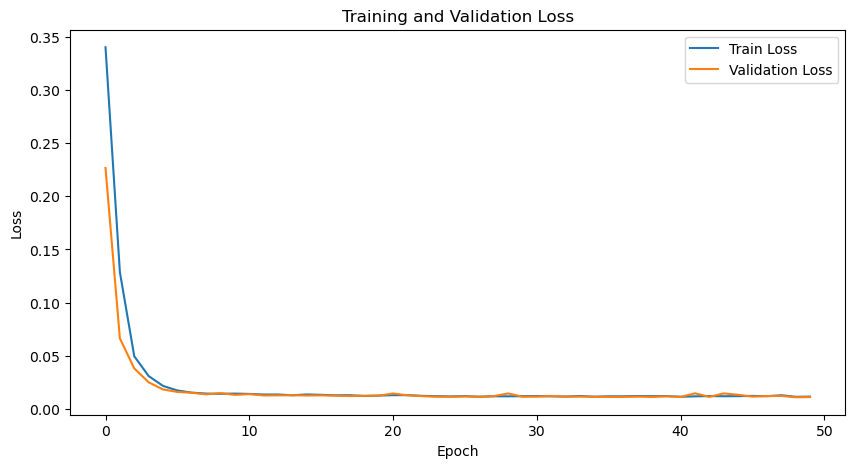

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


# Testing

In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import joblib

dx_dy = 0.0333958286584664
dt = 0.025

model_path = 'final_op/ori_2_128/o2_128.pth'
input_scaler_path = 'final_op/ori_2_128/scalers/best_input_scaler.pkl'
output_scaler_path = 'final_op/ori_2_128/scalers/best_output_scaler.pkl'
input_scaler = joblib.load(input_scaler_path)
output_scaler = joblib.load(output_scaler_path)

In [2]:
output_folder = "final_op/ori_2_128"
os.makedirs(output_folder, exist_ok=True)
csv_folder = os.path.join(output_folder, "csv")
plots_folder = os.path.join(output_folder, "plots")
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(plots_folder, exist_ok=True)

In [3]:
class SimpleFeedForwardNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleFeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleFeedForwardNN(input_dim=576, hidden_dim=128, output_dim=576).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

test_runs = [22, 26, 30, 34, 48]
j_range = range(1, 41)
time_data = pd.read_csv('TimeAxis.csv', header=None).iloc[0].values

In [5]:
def scale_pulse(image, pulse, dx_dy=dx_dy, dt=dt):
    image_energy = image.sum() * dx_dy
    pulse_energy = pulse.sum() * dt
    K = image_energy / pulse_energy
    scaled_pulse = K * pulse
    return scaled_pulse

In [6]:
total_mse = 0
total_energy_difference = 0
total_files = 0
results = []


for run in test_runs:
    for j in j_range:
        input_pulse_path = f'../Data/TemporalTestData/Run {run} - BL4, s39708/Run_{run}_BL4_s39708_InjPulsePower_InjEnergyFactor_{j}.csv'
        input_image_path = f'../Data/SpatialTestData/Run {run} - BL4, s39708/Run_{run}_BL4_s39708_Inj_256x256_InjEnergyFactor_{j}.csv'
        ground_truth_file_path = f'../Data/TemporalTestData/Run {run} - BL4, s39708/Run_{run}_BL4_s39708_UVDBS_Power_InjEnergyFactor_{j}.csv'

        if os.path.isfile(input_pulse_path) and os.path.isfile(input_image_path) and os.path.isfile(ground_truth_file_path):
            input_pulse = pd.read_csv(input_pulse_path, header=None).iloc[0].values
            input_image = pd.read_csv(input_image_path, header=None).values
            scaled_input_pulse = scale_pulse(input_image, input_pulse)
            input_data = scaled_input_pulse[59:59+576]
            ground_truth_data = pd.read_csv(ground_truth_file_path, header=None).iloc[0].values[59:]

            input_data_scaled = input_scaler.transform(input_data.reshape(1, -1))
            input_tensor = torch.tensor(input_data_scaled, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction_scaled = model(input_tensor).cpu().numpy().squeeze()
                prediction_original_scale = output_scaler.inverse_transform(prediction_scaled.reshape(1, -1)).squeeze()

            # Calculate metrics
            mse = mean_squared_error(ground_truth_data, prediction_original_scale)
            predicted_energy = prediction_original_scale.sum() * dt
            ground_truth_energy = ground_truth_data.sum() * dt
            energy_difference = abs(predicted_energy - ground_truth_energy)
            
            total_mse += mse
            total_energy_difference += energy_difference
            total_files += 1

            results.append({
                "Run": run,
                "File": j,
                "MSE": mse,
                "Predicted Energy": predicted_energy,
                "Ground Truth Energy": ground_truth_energy,
                "Energy Difference": energy_difference
            })
            
            predictions_path = os.path.join(csv_folder, f"Run_{run}_j_{j}_predictions.csv")
            pd.DataFrame(prediction_original_scale).to_csv(predictions_path, index=False, header=False)
            
            ground_truth_data_normalized = ground_truth_data / ground_truth_data.max()
            prediction_normalized = prediction_original_scale / prediction_original_scale.max()
            input_data_normalized = input_data / input_data.max()

            plt.figure(figsize=(10, 5))
            plt.plot(time_data, input_data_normalized, label='Normalized Input Pulse Shape', color='steelblue')
            plt.plot(time_data, prediction_normalized, label='Normalized Predicted Output Pulse Shape', color='green')
            plt.plot(time_data, ground_truth_data_normalized, label='Normalized Ground Truth Pulse Shape', color='orange')
            plt.title(f'Normalized Input vs Predicted vs Ground Truth (Run {run}, File {j})')
            plt.xlabel('Time')
            plt.ylabel('Power Factor')
            plt.legend()
            plt.tight_layout()
            plot_path = os.path.join(plots_folder, f"Run_{run}_j_{j}_comparison.png")
            plt.savefig(plot_path)
            plt.close()

            print(f"Run {run}, File {j} -> MSE: {mse:.4f}, Predicted Energy: {predicted_energy:.4f}, "
                  f"Ground Truth Energy: {ground_truth_energy:.4f}, Energy Difference: {energy_difference:.4f}")
        else:
            print(f"Files not found for Run {run}, File {j}")


Run 22, File 1 -> MSE: 0.3685, Predicted Energy: 0.4771, Ground Truth Energy: 1.0571, Energy Difference: 0.5801
Run 22, File 2 -> MSE: 0.0918, Predicted Energy: 4.0789, Ground Truth Energy: 5.3221, Energy Difference: 1.2432
Run 22, File 3 -> MSE: 0.1623, Predicted Energy: 16.1246, Ground Truth Energy: 13.8979, Energy Difference: 2.2267
Run 22, File 4 -> MSE: 0.3321, Predicted Energy: 33.1253, Ground Truth Energy: 28.0902, Energy Difference: 5.0350
Run 22, File 5 -> MSE: 0.3854, Predicted Energy: 50.7188, Ground Truth Energy: 47.7449, Energy Difference: 2.9740
Run 22, File 6 -> MSE: 0.3681, Predicted Energy: 74.5531, Ground Truth Energy: 73.0204, Energy Difference: 1.5327
Run 22, File 7 -> MSE: 0.6363, Predicted Energy: 110.7675, Ground Truth Energy: 103.5129, Energy Difference: 7.2546
Run 22, File 8 -> MSE: 1.1843, Predicted Energy: 150.4389, Ground Truth Energy: 138.9285, Energy Difference: 11.5105
Run 22, File 9 -> MSE: 1.5388, Predicted Energy: 191.6710, Ground Truth Energy: 178.901

Run 26, File 32 -> MSE: 40.3959, Predicted Energy: 1769.2596, Ground Truth Energy: 1839.7134, Energy Difference: 70.4538
Run 26, File 33 -> MSE: 43.1471, Predicted Energy: 1846.7111, Ground Truth Energy: 1919.1661, Energy Difference: 72.4549
Run 26, File 34 -> MSE: 46.5872, Predicted Energy: 1924.1625, Ground Truth Energy: 1998.6774, Energy Difference: 74.5149
Run 26, File 35 -> MSE: 50.7696, Predicted Energy: 2001.6141, Ground Truth Energy: 2078.1881, Energy Difference: 76.5740
Run 26, File 36 -> MSE: 55.8368, Predicted Energy: 2079.0654, Ground Truth Energy: 2157.6918, Energy Difference: 78.6264
Run 26, File 37 -> MSE: 61.9172, Predicted Energy: 2156.5168, Ground Truth Energy: 2237.1499, Energy Difference: 80.6331
Run 26, File 38 -> MSE: 69.1744, Predicted Energy: 2233.9684, Ground Truth Energy: 2316.5365, Energy Difference: 82.5682
Run 26, File 39 -> MSE: 77.7849, Predicted Energy: 2311.4197, Ground Truth Energy: 2395.8236, Energy Difference: 84.4039
Run 26, File 40 -> MSE: 87.9048,

Run 34, File 23 -> MSE: 1.0135, Predicted Energy: 1082.3078, Ground Truth Energy: 1087.9584, Energy Difference: 5.6506
Run 34, File 24 -> MSE: 0.9020, Predicted Energy: 1157.1365, Ground Truth Energy: 1162.2893, Energy Difference: 5.1528
Run 34, File 25 -> MSE: 0.6509, Predicted Energy: 1233.1416, Ground Truth Energy: 1237.2706, Energy Difference: 4.1290
Run 34, File 26 -> MSE: 0.5287, Predicted Energy: 1309.4122, Ground Truth Energy: 1312.8127, Energy Difference: 3.4005
Run 34, File 27 -> MSE: 0.4276, Predicted Energy: 1385.7344, Ground Truth Energy: 1388.8284, Energy Difference: 3.0940
Run 34, File 28 -> MSE: 0.4193, Predicted Energy: 1462.0723, Ground Truth Energy: 1465.2457, Energy Difference: 3.1734
Run 34, File 29 -> MSE: 0.4317, Predicted Energy: 1538.7105, Ground Truth Energy: 1542.0051, Energy Difference: 3.2945
Run 34, File 30 -> MSE: 0.4529, Predicted Energy: 1615.5092, Ground Truth Energy: 1619.0377, Energy Difference: 3.5285
Run 34, File 31 -> MSE: 0.4961, Predicted Energy

In [7]:
results_df = pd.DataFrame(results)
results_csv_path = os.path.join(output_folder, "finaltesting_results_2o128.csv")
results_df.to_csv(results_csv_path, index=False)

In [8]:
average_mse = total_mse / total_files
mean_energy_difference = total_energy_difference / total_files
print(f"\nOverall Metrics")
print(f"Average MSE: {average_mse:.4f}")
print(f"Mean Energy Difference: {mean_energy_difference:.4f}")


Overall Metrics
Average MSE: 9.2665
Mean Energy Difference: 21.4193
